# Chapter 5 - Applying Convnets to The Dogs vs Cats using Feature extraction (VGG16) and data augmentation

In [1]:
# Importing PlaidML. Make sure you follow this order
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [8]:
from keras.datasets import mnist
from keras import models, layers
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import shutil
import os

import matplotlib.pyplot as plt

In [3]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

## Loading dataset

In [4]:
if 'DATASET_CATS_DOGS' in os.environ:
    original_dataset_dir = os.environ['DATASET_CATS_DOGS']
else:
    original_dataset_dir = "/Users/adriano.gil/workspace/datasets/dogs-vs-cats/train/"

if 'DATASET_CATS_DOGS_SMALL' in os.environ:
    base_dir = os.environ["DATASET_CATS_DOGS_SMALL"]
else:
    base_dir = "/Users/adriano.gil/workspace/datasets/dogs-vs-cats-small"
create_dir(base_dir)

In [5]:
train_dir = os.path.join(base_dir, 'train')
create_dir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
create_dir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
create_dir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
create_dir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
create_dir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
create_dir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
create_dir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
create_dir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
create_dir(test_dogs_dir)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [6]:
print('Total training cat images: ', len(os.listdir(train_cats_dir)))
print('Total training dog images: ', len(os.listdir(train_dogs_dir)))
print('Total validation cat images: ', len(os.listdir(validation_cats_dir)))
print('Total validation dog images: ', len(os.listdir(validation_dogs_dir)))
print('Total test cat images: ', len(os.listdir(test_cats_dir)))
print('Total test dogs images: ', len(os.listdir(test_dogs_dir)))

Total training cat images:  1000
Total training dog images:  1000
Total validation cat images:  500
Total validation dog images:  500
Total test cat images:  500
Total test dogs images:  500


## Preparing data (using data-augumentation generators)

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Instantiating the VGG16 convolutional base

In [10]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
conv_base.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPo

## Generating Models

In [11]:
def build_model():
    conv_base.trainable = False
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizers.RMSprop(lr=1e-4),
        loss='binary_crossentropy',
        metrics=['acc']
    )
    return model

In [12]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


## Training model

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)
model.save('catas_and_dogs_small_4.h5')

Epoch 1/100
100/100 [==============================] - 118s 1s/step - loss: 0.5530 - acc: 0.7070 - val_loss: 0.3716 - val_acc: 0.8350
Epoch 2/100
100/100 [==============================] - 132s 1s/step - loss: 0.4257 - acc: 0.7980 - val_loss: 0.3300 - val_acc: 0.8420
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.3582 - acc: 0.8429

KeyboardInterrupt: 

## Displaying curves of loss and accuracy during training

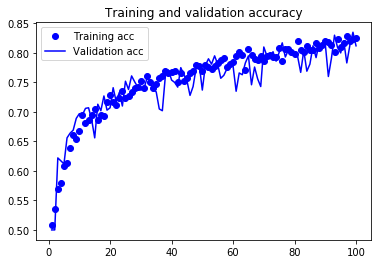

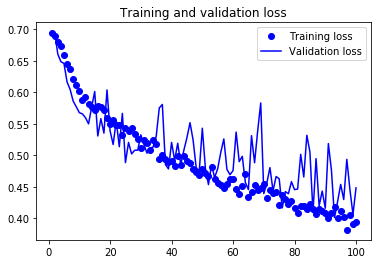

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
